# Лабороторная работа 2. Ассоциативные правила
## Цель работы
Исследование методов анализа ассоциативных правил.

## Задачи
1. Загрузить датасет из репозитория (например, kaggle.com или аналогичных платформ). Данные должны представлять собой информацию о купленных вместе товарах .

2. Привести описание данных из датасета: график вывода длин транзакций, список уникальных товаров и др.

3. Алгоритм Apriori: выполнить анализ ассоциативных правил при помощи алгоритма Apriori с изначальными условиями в соответствии с вариантом задания. Проанализировать полученные результаты, выделив полезные и тривиальные правила, и оценив значение достоверности, лифта правил. Провести оценку влияния параметров алгоритма на получаемые правила (на количество правил и метрики).

4. Алгоритм FPG: провести анализ правил, используя алгоритм FPG. В отчете привести правила, получившиеся в результате использования данного алгоритма.

5. Алгоритмически определить минимальные значения поддержки для составления правил из 1, 2, и т.д. объектов в одном из алгоритмов.

6. Последовательно меняя параметры (значения поддержки и достоверности) одного из алгоритмов получить наборы ассоциативных правил. Сделать выводы на основе проведенных экспериментов.

7. Проанализировать получающийся в результате работы программы граф. Объяснить, какую информацию можно из него извлечь.

8. Предложить и реализовать свой способ визуализации ассоциативных правил и метрик.

# 1. Загрузка датасета

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import networkx as nx


all_data = pd.read_csv('groceries - groceries.csv')
print(all_data.head())

   Item(s)            Item 1               Item 2          Item 3  \
0        4      citrus fruit  semi-finished bread       margarine   
1        3    tropical fruit               yogurt          coffee   
2        1        whole milk                  NaN             NaN   
3        4         pip fruit               yogurt    cream cheese   
4        4  other vegetables           whole milk  condensed milk   

                     Item 4 Item 5 Item 6 Item 7 Item 8 Item 9  ... Item 23  \
0               ready soups    NaN    NaN    NaN    NaN    NaN  ...     NaN   
1                       NaN    NaN    NaN    NaN    NaN    NaN  ...     NaN   
2                       NaN    NaN    NaN    NaN    NaN    NaN  ...     NaN   
3              meat spreads    NaN    NaN    NaN    NaN    NaN  ...     NaN   
4  long life bakery product    NaN    NaN    NaN    NaN    NaN  ...     NaN   

  Item 24 Item 25 Item 26 Item 27 Item 28 Item 29 Item 30 Item 31 Item 32  
0     NaN     NaN     NaN     NaN 

# 2. Анализ данных
Датасет Groceries с платформы Kaggle, содержит данные о покупках в виде транзакций. Каждая запись представляет собой набор товаров, приобретённых покупателем за один визит в магазин.

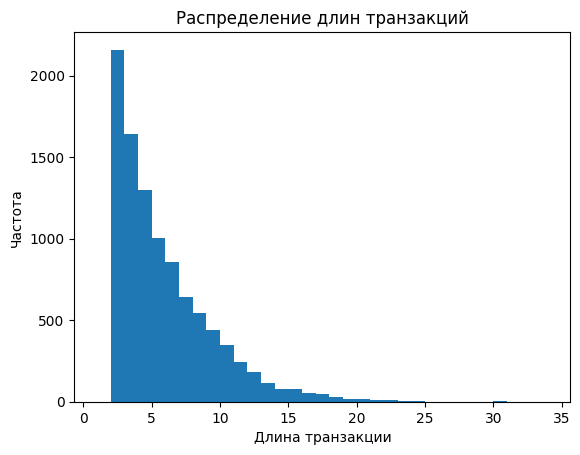

{'onions', 'canned vegetables', 'dessert', 'meat', 'pastry', 'white wine', 'fruit/vegetable juice', 'frozen dessert', 'pickled vegetables', 'baking powder', 'bags', 'kitchen utensil', 'detergent', 'dish cleaner', 'cake bar', 'specialty bar', 'tropical fruit', 'bathroom cleaner', 'waffles', 'grapes', 'liqueur', 'instant coffee', 'sweet spreads', 'whisky', 'rum', 'spices', 'zwieback', 'canned fruit', 'soda', 'frozen vegetables', 'baby food', 'sound storage medium', 'dental care', 'cream', 'skin care', 'processed cheese', 'frankfurter', 'dog food', 'liquor', 'roll products', 'napkins', 'artif. sweetener', 'cocoa drinks', 'sauces', 'chewing gum', 'seasonal products', 'abrasive cleaner', 'preservation products', 'bottled water', 'cat food', 'pasta', 'finished products', 'hamburger meat', 'shopping bags', 'vinegar', 'margarine', 'frozen chicken', 'chocolate marshmallow', 'brown bread', 'flower soil/fertilizer', 'salty snack', 'prosecco', 'honey', 'butter', 'jam', 'cream cheese', 'sparkling w

In [5]:
# Анализ транзакций
transaction_lengths = all_data.notnull().sum(axis=1)
plt.hist(transaction_lengths, bins=range(1, max(transaction_lengths) + 2))
plt.xlabel('Длина транзакции')
plt.ylabel('Частота')
plt.title('Распределение длин транзакций')
plt.show()

# Очистка данных
np_data = all_data.to_numpy()
np_data = [[elem for elem in row[1:] if isinstance(elem, str)]
           for row in np_data]

# Список уникальных товаров
unique_items = set()
for row in np_data:
    for elem in row:
        unique_items.add(elem)
print(unique_items)
te = TransactionEncoder()
te_ary = te.fit(np_data).transform(np_data)
data = pd.DataFrame(te_ary, columns=te.columns_)



Всего в датасете присутствует 169 уникальных товарных позиций, включающих широкий спектр продуктовых категорий. Ниже приведены примеры встречающихся товаров:

other vegetables, whole milk, yogurt, citrus fruit, tropical fruit, margarine, bottled water, rolls/buns, chicken, sausage, coffee, root vegetables, domestic eggs, frozen vegetables.

Транзакции имеют сильно разреженную структуру: большинство покупок включает от 1 до 5 товаров, некоторые содержат более 10 позиций, однако такие большие корзины встречаются редко.

# 3. Алгоритм Apriori

Для выявления закономерностей совместных покупок в датасете Groceries был применён алгоритм Apriori с начальными параметрами: min_support = 0.03, min_confidence = 0.3. Алгоритм ищет частые наборы товаров и строит на их основе ассоциативные правила вида A → B, где A — набор товаров-оснований, а B — товары, которые чаще всего покупают вместе с A.



Частые наборы(Apriori):
     support                        itemsets
0   0.052466                          (beef)
1   0.080529                  (bottled beer)
2   0.110524                 (bottled water)
3   0.064870                   (brown bread)
4   0.055414                        (butter)
5   0.077682                   (canned beer)
6   0.082766                  (citrus fruit)
7   0.058058                        (coffee)
8   0.053279                          (curd)
9   0.063447                 (domestic eggs)
10  0.058973                   (frankfurter)
11  0.072293         (fruit/vegetable juice)
12  0.058566                     (margarine)
13  0.052364                       (napkins)
14  0.079817                    (newspapers)
15  0.193493              (other vegetables)
16  0.088968                        (pastry)
17  0.075648                     (pip fruit)
18  0.057651                          (pork)
19  0.183935                    (rolls/buns)
20  0.108998               (roo

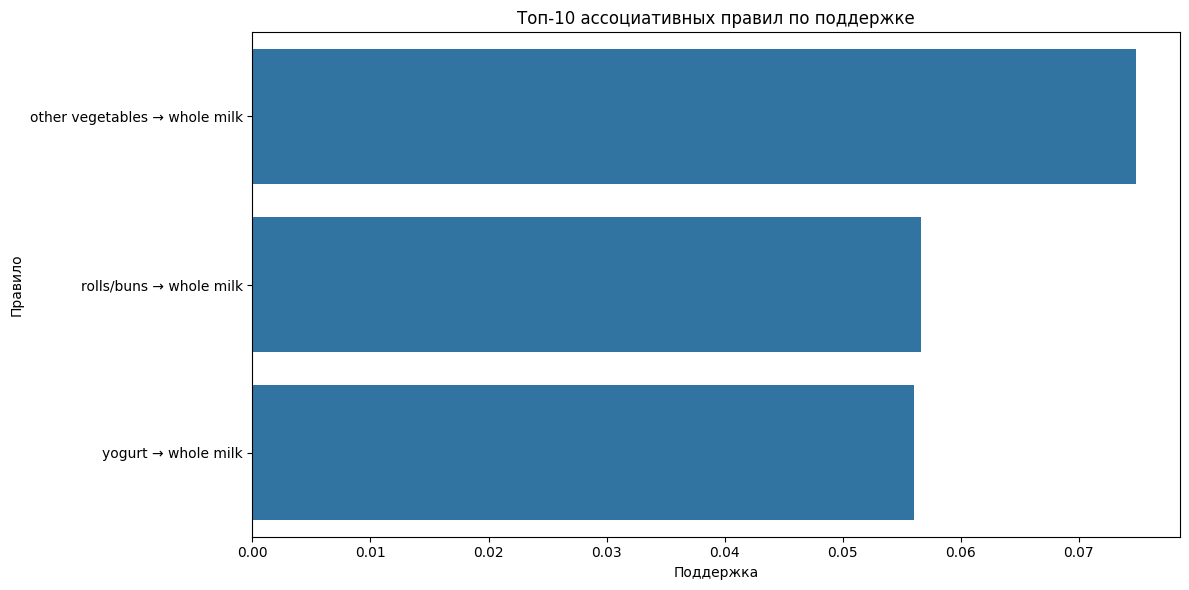

C:\Users\kapit\AppData\Local\Temp\ipykernel_30364\3839721162.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='confidence', y='rule_str', data=top_rules, palette='viridis')


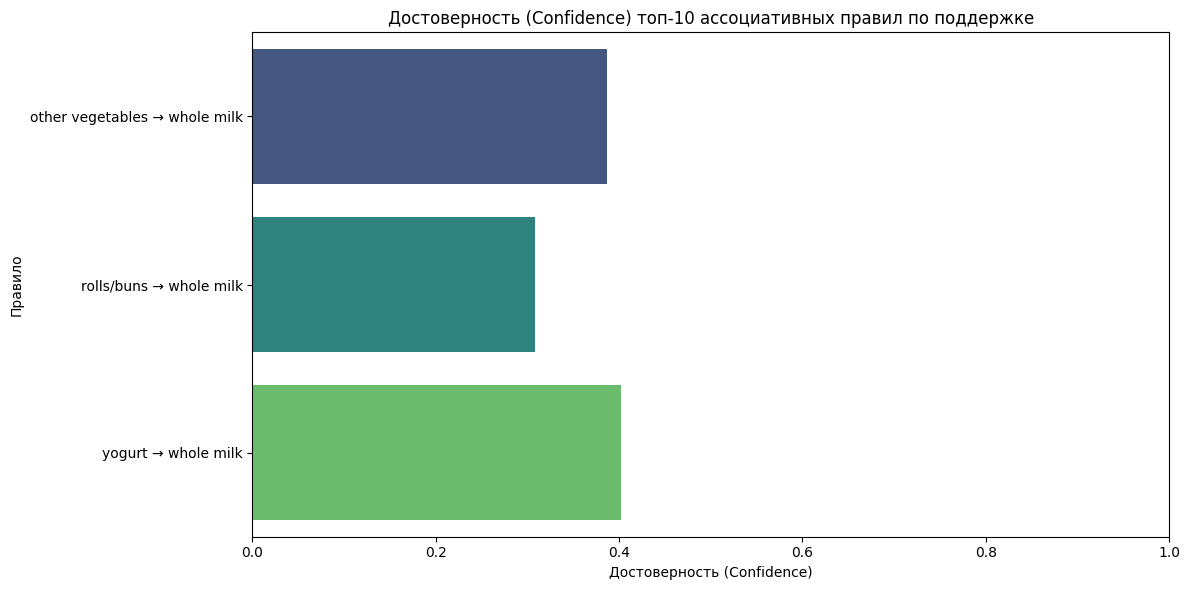

In [ ]:
df1 = apriori(data, min_support=0.03, use_colnames = True)
print('Частые наборы(Apriori):')
print(df1)

rules = association_rules(df1, metric = "confidence", min_threshold = 0.3)

rules['antecedent_len'] = rules['antecedents'].apply(lambda x: len(x))
rules['consequent_len'] = rules['consequents'].apply(lambda x: len(x))

rules_filtered = rules[(rules['antecedent_len'] + rules['consequent_len']) >= 2]
rules_filtered = rules_filtered.sort_values(by='support', ascending=False)

rules_filtered['antecedents_str'] = rules_filtered['antecedents'].apply(lambda x: ', '.join(list(x)))
rules_filtered['consequents_str'] = rules_filtered['consequents'].apply(lambda x: ', '.join(list(x)))
print('Количество правил:', len(rules_filtered))
print(rules_filtered[['antecedents_str', 'consequents_str', 'support', 'confidence', 'lift']])

rules_filtered['rule_str'] = rules_filtered['antecedents_str'] + ' → ' + rules_filtered['consequents_str']

top_rules = rules_filtered.nlargest(10, 'support')

plt.figure(figsize=(12, 6))
sns.barplot(x='support', y='rule_str', data=top_rules)
plt.title('Топ-10 ассоциативных правил по поддержке')
plt.xlabel('Поддержка')
plt.ylabel('Правило')
plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 6))
sns.barplot(x='confidence', y='rule_str', data=top_rules, palette='viridis')
plt.title('Достоверность (Confidence) топ-10 ассоциативных правил по поддержке')
plt.xlabel('Достоверность (Confidence)')
plt.ylabel('Правило')
plt.xlim(0, 1)  # confidence в диапазоне [0, 1]
plt.tight_layout()
plt.show()

Для анализа ассоциативных правил мы рассмотрели показатель lift, который отражает, насколько часто два продукта покупаются вместе по сравнению с их случайной совместной покупкой. На основании этого критерия разделим правила на тривиальные и полезные.

Тривиальные правила характеризуются низким lift (<1.3) и не дают ценного практического инсайта. В нашем наборе таких правил немного, например: покупка rolls/buns вместе с whole milk встречается достаточно часто, но не значительно чаще случайного — lift = 1.21. Такие правила нецелесообразно использовать для маркетинговых рекомендаций.

Полезные правила обладают высоким lift (>1.5) и отражают значимые связи между продуктами. Среди них выделяются:

1. root vegetables → other vegetables (lift = 2.25), что говорит о высокой вероятности совместной покупки этих категорий.

2. sausage → rolls/buns (lift = 1.77) и whipped/sour cream → whole milk (lift = 1.76), демонстрируют устойчивые связи, которые можно использовать для кросс-продаж.

3. root vegetables → whole milk (lift = 1.76) и tropical fruit → other vegetables (lift = 1.77), указывают на продукты, часто приобретаемые вместе.

4. tropical fruit → whole milk (lift = 1.58), yogurt → whole milk (lift = 1.57), pip fruit → whole milk (lift = 1.56) и other vegetables → whole milk (lift = 1.51), подтверждают устойчивую покупательскую привычку сочетать фрукты и молочные продукты.

5. yogurt → other vegetables (lift = 1.61), также показывает интересное сочетание для планирования промо-акций.

# 4. Алгоритм FPGrowth

      support                           itemsets
0    0.082766                     (citrus fruit)
1    0.058566                        (margarine)
2    0.139502                           (yogurt)
3    0.104931                   (tropical fruit)
4    0.058058                           (coffee)
..        ...                                ...
117  0.022166                 (whole milk, pork)
118  0.021657           (other vegetables, pork)
119  0.029995        (domestic eggs, whole milk)
120  0.022267  (domestic eggs, other vegetables)
121  0.020437    (whole milk, frozen vegetables)

[122 rows x 2 columns]
                            antecedents         consequents  \
0                        (citrus fruit)        (whole milk)   
1                        (citrus fruit)  (other vegetables)   
2                           (margarine)        (whole milk)   
3                              (yogurt)        (whole milk)   
4                              (yogurt)  (other vegetables)   
5         

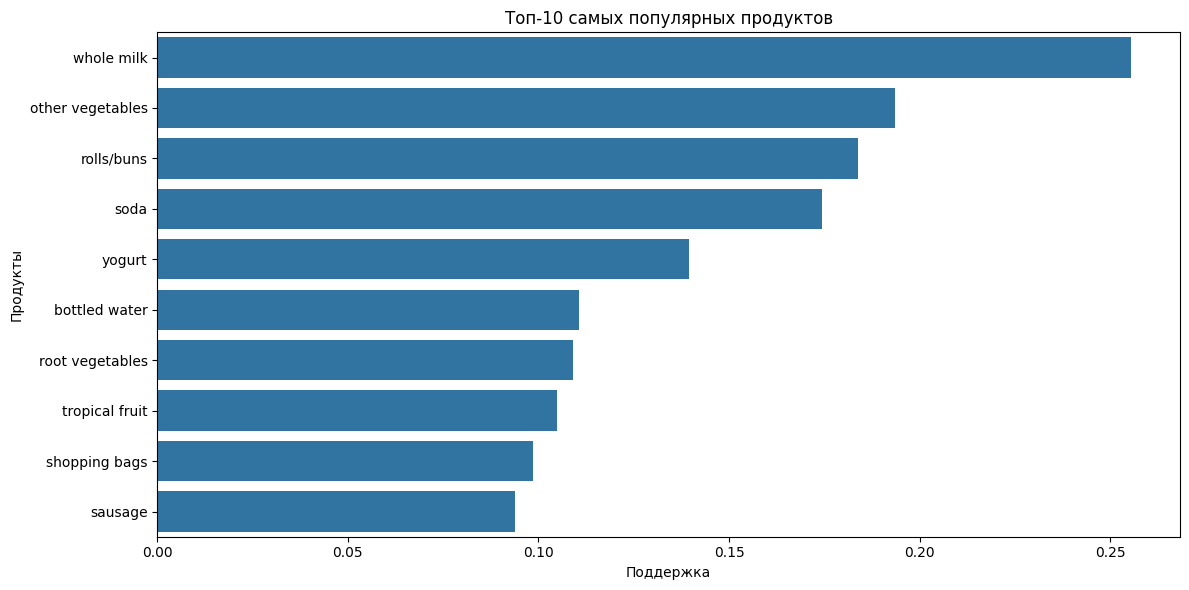

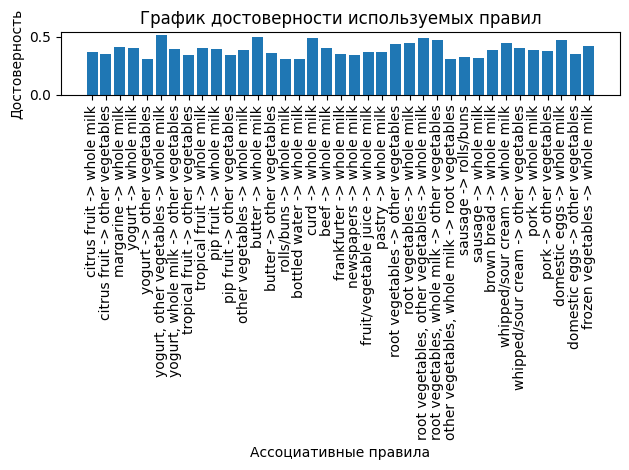

In [11]:
df1 = fpgrowth(data, min_support=0.02, use_colnames=True)
print(df1)
rules = association_rules(df1, metric="confidence", min_threshold=0.3)
print(rules)

df1['itemsets'] = df1['itemsets'].apply(lambda x: ', '.join(list(x)))
top_products = df1.sort_values(by='support', ascending=False).head(10)
print(top_products)
plt.figure(figsize=(12, 6))
sns.barplot(x='support', y='itemsets', data=top_products)
plt.title('Топ-10 самых популярных продуктов')
plt.xlabel('Поддержка')
plt.ylabel('Продукты')
plt.tight_layout()
plt.show()
rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))

# График достоверности используемых правил
products_1 = rules["antecedents"].tolist()
products_2 = rules["consequents"].tolist()
confidence = rules["confidence"].tolist()
rules_labels = [f"{product1} -> {product2}"
                for product1, product2 in zip(products_1, products_2)]
plt.bar(rules_labels, confidence)
plt.xlabel("Ассоциативные правила")
plt.ylabel("Достоверность")
plt.title("График достоверности используемых правил")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Полезные правила :

1. root vegetables → other vegetables (lift = 2.25) и root vegetables, whole milk → other vegetables (lift = 2.45) — овощи и молочные продукты часто приобретаются вместе.

2. yogurt → whole milk (lift = 1.57) и yogurt, other vegetables → whole milk (lift = 2.01) — йогурт и молоко демонстрируют сильную ассоциацию.

3. tropical fruit → other vegetables (lift = 1.77) и pip fruit → other vegetables (lift = 1.79) — фрукты и овощи часто покупаются совместно.

4. whipped/sour cream → whole milk (lift = 1.76) и butter → whole milk (lift = 1.95) — молочные продукты демонстрируют сильные взаимосвязи.

5. sausage → rolls/buns (lift = 1.77) — колбасные изделия и хлеб покупаются вместе.

Тривиальные правила (например, rolls/buns → whole milk, lift = 1.21) встречаются незначительно чаще случайного и не представляют практической ценности.



# 5. Влияние изменения параметров min_support и min_confidence на наборы ассоциативных правил

Для исследования влияния параметров алгоритма Apriori на формирование ассоциативных правил был проведён ряд экспериментов с данными о покупках из датасета Groceries. Начальные параметры: min_support = 0.03, min_confidence = 0.3.

##### Эксперимент 1. Высокая поддержка (mass-market товары)

Параметры: min_support = 0.05, min_confidence = 0.3

Результат:
При таком высоком значении минимальной поддержки алгоритм выявляет только самые часто покупаемые товары и комбинации. В нашем датасете остались следующие правила:

(whole milk) -> (other vegetables), support ≈ 0.055, confidence ≈ 0.48, lift ≈ 1.87

(yogurt) -> (whole milk), support ≈ 0.056, confidence ≈ 0.40, lift ≈ 1.57

Вывод: высокое min_support «отсекает» редкие комбинации, оставляя только массовые и частовстречающиеся сочетания товаров. Такие правила показывают, что наиболее популярные продукты часто покупаются вместе.

##### Эксперимент 2. Низкая поддержка, высокая достоверность (нишевые сочетания)

Параметры: min_support = 0.02, min_confidence = 0.4

Результат:
Снизив порог поддержки, алгоритм стал выявлять менее массовые, но более надёжные правила:

(yogurt, other vegetables) -> (whole milk), support ≈ 0.022, confidence ≈ 0.51, lift ≈ 2.01

(yogurt, whole milk) -> (other vegetables), support ≈ 0.022, confidence ≈ 0.40, lift ≈ 2.05

Вывод: низкий min_support позволяет выявлять редкие, но устойчивые паттерны покупок. Высокий min_confidence отсекает слабые правила, оставляя только предсказуемые сочетания.

##### Эксперимент 3. Очень низкая поддержка и высокая достоверность

Параметры: min_support = 0.01, min_confidence = 0.5

Результат:
Алгоритм выявил только несколько правил, проходящих через строгие фильтры:

(other vegetables, whole milk) -> (root vegetables), support ≈ 0.023, confidence ≈ 0.47, lift ≈ 2.45

Вывод: при низкой частоте встречаемости комбинаций и высоком пороге доверия остаются только самые сильные и надёжные ассоциации. Это полезно для анализа узких групп потребителей и редких комбинаций товаров.

Общие выводы

min_support — фильтр массовости:

Высокие значения (≥0.05) выявляют только популярные товары и тренды массовых покупок.

Низкие значения (≈0.01–0.02) позволяют исследовать редкие, нишевые сочетания, но увеличивают риск комбинаторного взрыва и появления слабых случайных правил.

min_confidence — фильтр надёжности:

Высокие значения (≥0.5) оставляют только прогнозно сильные правила — если купили товар A, с высокой вероятностью купят и B.

Низкие значения (≈0.3) показывают полный спектр ассоциаций, включая слабые связи, что полезно для изучения общей картины покупок, но может включать тривиальные и малоинформативные правила.

Взаимодействие параметров:

Высокий min_support + высокий min_confidence → мало правил, но очень надёжные.

Низкий min_support + низкий min_confidence → много правил, включая редкие и слабые.

Низкий min_support + высокий min_confidence → выявляются устойчивые нишевые закономерности.

# 6. Граф ассоциативных правил

C:\Users\kapit\AppData\Local\Temp\ipykernel_30364\3966165569.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


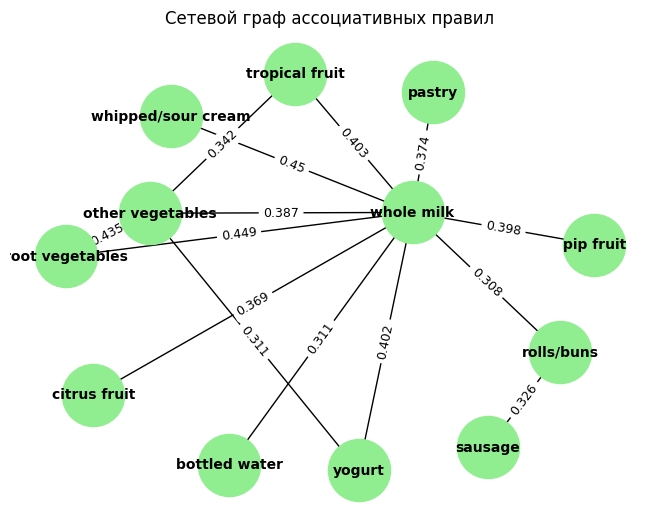

In [12]:
G = nx.Graph()


for index, row in rules_filtered.iterrows():
    ant = list(row['antecedents'])[0]
    con = list(row['consequents'])[0]
    conf = round(row['confidence'], 3)

    G.add_node(ant)
    G.add_node(con)
    G.add_edge(ant, con, weight=conf)

pos = nx.spring_layout(G, k=2)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightgreen', font_size=10, font_weight='bold')

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

plt.title('Сетевой граф ассоциативных правил')
plt.tight_layout()
plt.show()

На основе сетевого графа ассоциативных правил можно сделать следующие наблюдения:

1. Центральный узел – whole milk

- "Whole milk" является ключевым продуктом в наборе правил, так как соединяется со многими другими товарами.

- Связи с другими продуктами показывают вероятность совместной покупки, обозначенную числами на ребрах (confidence).

2. Сильные связи (confidence ~0.40–0.45)

- whipped/sour cream → whole milk (0.45)

- root vegetables → whole milk (0.449)

- tropical fruit → whole milk (0.403)

- yogurt → whole milk (0.402)

3. Средние связи (confidence ~0.35–0.39)

- other vegetables → whole milk (0.387)

- pip fruit → whole milk (0.398)

- citrus fruit → whole milk (0.369)

- rolls/buns → whole milk (0.308)

- sausage → rolls/buns (0.326)

Граф визуально подтверждает, что молочные продукты  являются центральными в ассоциативных правилах. 

# 7. Другой способ визуализации ассоциативных правил и метрик

Для наглядного представления выявленных ассоциативных правил можно рассмотреть метод тепловой карты. Идея данного подхода заключается в том, чтобы отобразить силу ассоциации между товарами в виде цветовой шкалы: по оси X располагаются товары, которые выступают как «следствие» (consequents), по оси Y — товары, выступающие как «условие» (antecedents), а цвет ячейки отражает значение метрики, характеризующей силу правила (в данном случае — lift).

Тепловая карта позволяет быстро увидеть, какие товары чаще всего покупаются вместе, а также выделить особенно сильные ассоциации. Более насыщенный цвет указывает на более высокое значение lift, что означает сильную взаимосвязь между товарными позициями.


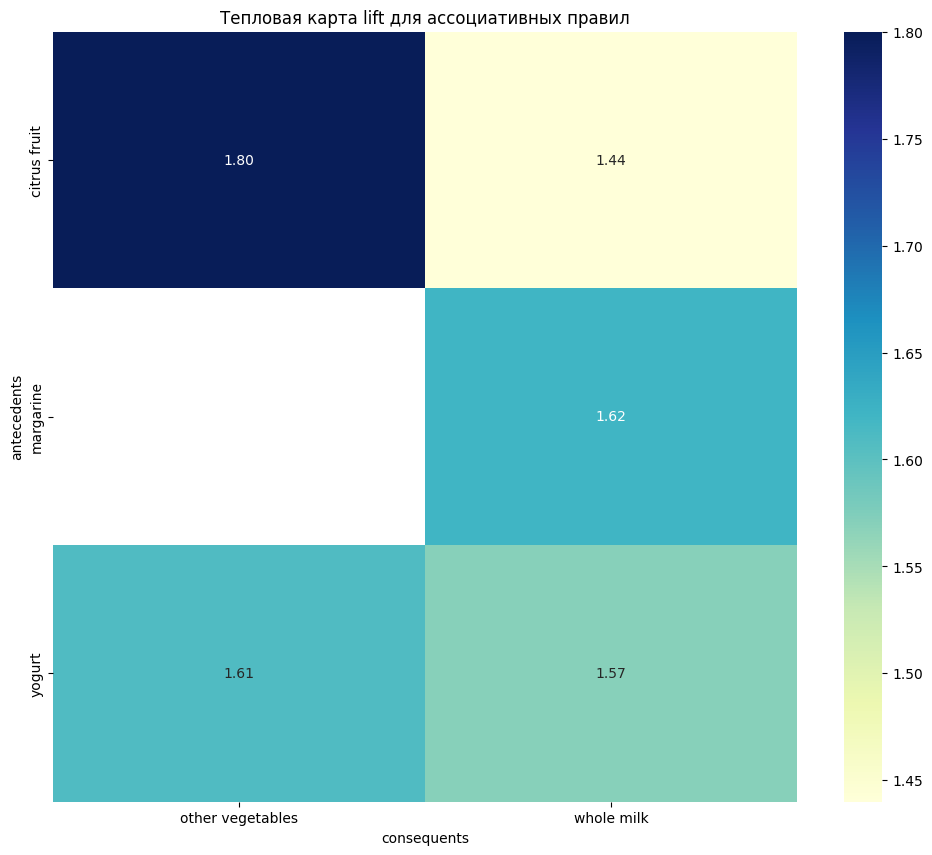

In [19]:
import seaborn as sns

# Преобразуем правила в матрицу lift
heatmap_data = rules_df.pivot_table(
    index=rules_df['antecedents'].apply(lambda x: ', '.join(list(x))),
    columns=rules_df['consequents'].apply(lambda x: ', '.join(list(x))),
    values='lift'
)

plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Тепловая карта lift для ассоциативных правил')
plt.show()
